# SLT-CE-6: Pairwise Clustering

<h2 style="background-color:#f0b375;"> References </h2>

<ol>
<li> Pairwise Data Clustering by Deterministic Annealing <br>
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.9812&rep=rep1&type=pdf
</li>
</ol>

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import SpectralClustering
from scipy.io import loadmat

<h2 style="background-color:#f0b375;"> Data </h2>

## ProDom Data
http://prtools.org/disdatasets/index.html#ProDom

In [2]:
prodom = {"input": loadmat("prodom.mat")}
# After some reverse-engineering:
prodom["similarity"] = np.array(prodom["input"]["s"])[0,0][0]
prodom["labels"] =np.array(prodom["input"]["s"])[0,0][2].flatten()

## Protein Data

http://prtools.org/disdatasets/index.html#Protein

In [3]:
protein = {"input": loadmat("protein.mat")}
protein["dissimilarity"] = np.array(protein["input"]["d"])[0,0][0]
protein["labels"] =np.array(protein["input"]["d"])[0,0][2].flatten()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Implement the function <b>plt_pairwise</b> according to its docstring.
</p>

In [4]:
def plt_pairwise(data, labels, cmap="binary", alpha=0.33):
    """Plot (dis-)similarity data
    
    Args:
        data (np.ndarray): Symmetric (dis-)similarity array (n_samples, n_samples)
        labels (np.array): Cluster label array  (n_samples,)
        cmap (str): Color Map for (dis-)similarity values
        alpha (float): Opacity of cluster overlay, between 0 and 1
        
    Shows:
        Image plot of (dis-)similarity matrix, overlaid with transparent blocks,
        which indicate the clusters contained in labels.
        Note: Permute the data according to the sorting of the labels.
        
    Prints:
        Minimum, Maximum and Median of (dis-)similarity values
        Warning, if (dis-)similarity matrix is not symmetric
    """
    print('data.min', data.min())
    print('data.median', np.median(data))
    print('data.max', data.max())
    asort = np.argsort(labels)
    plt.imshow(data[asort][:, asort], cmap='binary')
    overlay = np.zeros_like(data)
    uniq, cnt = np.unique(labels[asort], return_counts=True)
    cnt = np.cumsum(cnt)
    for idx, _ in enumerate(cnt):
        if idx == 0:
            overlay[:cnt[idx], :cnt[idx]] = uniq[idx]
        else:
            overlay[cnt[idx-1]:cnt[idx], cnt[idx-1]:cnt[idx]] = uniq[idx]
    plt.imshow(overlay, alpha=0.33)


data.min -15529
data.median -8847.0
data.max 478835


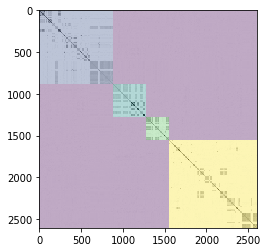

In [5]:
# This is how the output should look like
plt_pairwise(prodom["similarity"], prodom["labels"])

<p style="background-color:#adebad;">
    Demonstrate your implementation of <b> plt_pairwise </b> below.
</p>

data.min 0.0
data.median 11.23
data.max 13.64


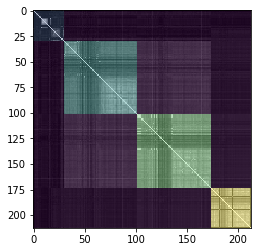

In [6]:
plt_pairwise(protein["dissimilarity"], protein["labels"], cmap="gray")

<p style="background-color:#adebad;">
    Read reference [1] and recapitulate their Algorithm II and III. <br>
    Make sure that every variable is properly defined in your recap.
</p>

Put your recap here

**Notation.**
1. $\mathcal D$ denotes the dissimlarity matrix.
2. $M_{i\nu} \in \{0, 1\}$ denotes whether datum $i$ is put in cluster $\nu$. $\left<M_{i\nu}\right>$ as the expected value of $M_{i\nu}$.
3. $\mathcal E_{i\nu}$ denotes the cost (potential) for putting datum $i$ into cluster $\nu$. $\mathcal E_{i\nu}^*$ denotes the optimal potential.
4. $N$ denotes the number of data.
5. $p_\nu := \frac{1}{N} \sum_{i=1}^N M_{i\nu}$ denotes the empirical probability of data being classified as cluster $\nu$.

**Algorithm II.**
1. Start by randomly initializing $\mathcal E_{i\nu}^*$ and $\left<M_{i\nu}\right>$.
2. While the temperature $T$ has yet to reach $T_f$,
    1. Repeat until convergence:
        1. $\left<M_{i\nu}\right> = \frac{\exp{(-\mathcal E_{i\nu}^*/T)}}{\sum_{\nu=1}^K \exp{(-\mathcal E_{i\nu}^*/T)}}$
        2. $\mathcal E_{i\nu}^* = \frac{1}{\left<p_\nu\right> N} \sum_{k=1}^N \left<M_{k\nu}\right> \left(\mathcal D_{ik} - \frac{1}{2\left<p_\nu\right> N} \sum_{j=1}^N\left<M_{j\nu}\right>\mathcal D_{jk}\right)$
    2. Reduce temperature
    
**Algorithm III.**

Additional notation: 
* $\hat{\bf x}_i$ and $\hat{\bf y}_\nu$ are the estimated embedding of datum $i$ and estimated centroid of cluster $\nu$ respectively.

With $\mathcal E_{i\nu}^* = ||{\bf x}_i - {\bf y}_\nu||^2$,

1. Start by randomly initializing $\hat{\bf x}_i$ and $\left<M_{i\nu}\right>$.
2. While the temperature $T$ has yet to reach $T_f$,
    1. Repeat until convergence:
        1. $\left<M_{i\nu}\right> = \frac{\exp{(-\mathcal E_{i\nu}^*/T)}}{\sum_{\nu=1}^K \exp{(-\mathcal E_{i\nu}^*/T)}}$.
        2. Repeat until convergence:
            1. ${\bf x}_i = \frac{1}{2}{\bf K}_i^{-1}\sum_{\nu=1}^K \left<M_{i\nu}\right> \left(||{\bf y}_\nu||^2 - \mathcal E_{i\nu}^*\right)\left({\bf y}_\nu - \sum_{\mu=1}^K\left<M_{i\mu}\right>{\bf y}_\mu\right)$, where ${\bf K}_i = \left<{\bf yy}^T\right>_i - \left<{\bf y}\right>_i\left<{\bf y}\right>^T_i$
            2. ${\bf y}_\nu = \frac{\sum_{k=1}^N M_{k\nu}{\bf x}_k}{\sum_{k=1}^N M_{k\nu}}$
    2. Reduce temperature

<p style="background-color:#adebad;">
    Implement the <b>fit_predict </b> method without embedding for the template class PairwiseClustering, according to its docstring. <br>
    You can add more class methods if necessary.
</p>

In [7]:
import scipy.spatial as sps
class PairwiseClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for PairwiseClustering (PC)
    
    Attributes:
        M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
        centroids (np.ndarray): Embedding centroids (n_clusters, n_components), used only if embed is True.
        embeddings (np.ndarray): Embeddings of input samples (n_samples, n_components),
                                 used only if embed is True.
    Parameters:
        n_clusters (int): Maximum number of clusters.
        random_state (int): Random seed.
        embed (bool): Indicator, if data should be clustered and embedded simultaneously (algorithm III),
                      or not (algorithm II).
        n_components (int): Dimension of embedding space, used only if embed is True
    """
    
    def __init__(self, n_clusters=4, random_state=42, embed=False, n_components=2):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.embed = embed
        self.n_components = n_components
        # Add more parameters, if necessary.
    
    def fit_predict(self, X, ti=10, tf=1e-2):
        """Compute PC for dissimilarity matrix X
        
        Compute cluster assignments. If embed is True, also compute embeddings/centroids.
         
        Args:
            X (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
        
        Returns:
            C (np.ndarray): Assignments (n_samples,) 
        """
        
        if self.embed:
            # Code for algorithm III
            N = X.shape[0]
            M = np.random.random((N, self.n_clusters))
            M /= np.sum(M, axis=1)[:, None]
            embeddings = np.random.normal(scale=100, size=(N, self.n_components)) # (N, D)
            centroids = np.zeros((self.n_clusters, self.n_components)) # (K, D)
            centroids += np.mean(embeddings, axis=0)
            centroids += np.random.normal(scale=0.1, size=centroids.shape)
            temperature = ti
            
            while temperature > tf:
#                 E = sps.distance.cdist(embeddings, centroids) # (N, K)
                pn = np.sum(M, axis=0) # <pv> N
                E = np.sum(M.T * (X[:, None] - (M.T.dot(X) / (2*pn[:, None]))[None]), axis=-1) / pn
                M = np.exp(-E / temperature)
                M = M / np.sum(M, axis=1)[:, None]
                
                for _ in range(1):
                    yy = np.einsum('ij,ik->ijk', centroids, centroids)
                    Eyy = np.einsum('ij,jkl->ikl', M, yy) # (N, D, D)
                    Ey = M.dot(centroids)
                    EyEy = np.einsum('ij,ik->ijk', Ey, Ey)
                    K = Eyy - EyEy # (N, D, D)

                    C = centroids[None] - M.dot(centroids)[:, None]
                    B = np.linalg.norm(centroids, axis=1)**2 - E
                    Kx = 0.5*np.sum(M[:,:,None]*B[:,:,None]*C, axis=1) # (N, D)

                    embeddings = np.einsum('ijk,ij->ik', np.linalg.pinv(K), Kx)
                    centroids = M.T.dot(embeddings) / np.sum(M, axis=0)[:, None]
                                    
                temperature *= 0.95
                
                print(embeddings)
                
            C = np.argmax(M, axis=1)
            self.embeddings = embeddings
            self.centroids = centroids
            return C
            
            
        else:
            # Code for algorithm II
            N = X.shape[0]
            cost = (np.random.normal(scale=10, size=(N, self.n_clusters))) # random init E; (N, K)
            temperature = ti
            
            while temperature > tf:
                for _ in range(5):
                    assignment = np.exp(-cost / temperature) / np.sum(np.exp(-cost/temperature), axis=1)[:, None]
                    pn = np.sum(assignment, axis=0) # <pv> N
                    cost = np.sum(assignment.T * (X[:, None] - (assignment.T.dot(X) / (2*pn[:, None]))[None]), axis=-1) / pn
                temperature *= 0.5
            C = np.argmax(assignment, axis=1)
            self.M = assignment
        return C
    
    def cost(self, D, M):
        """Compute the costs of the clustering solution M for dissimilarity D.
        
        The costs refer to the pairwise clustering costs in eq. (16) of reference [1].
        
        Args:
            D (np.ndarray): Dissimilarity matrix (n_samples, n_samples)
            M (np.ndarray): Assignment probability matrix (n_samples, n_clusters)
            
        Returns:
            cost (float): Costs of current clustering
        """
        N = M.shape[0]
        p = np.sum(M, axis=0) / N
        cost = np.sum(D * ((M/p).dot(M.T) - 1) / N) / 2
        
        return cost

<p style="background-color:#adebad;">
    Create an instance of your PC class, then fit and predict the Protein data. <br>
    Repeat the same with sklearn.SpectralClustering. <br>
    Record the execution time.
</p>

In [8]:
%%time
PC = PairwiseClustering()
labels_pair = PC.fit_predict(protein["dissimilarity"])
print(labels_pair)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 0 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0]
CPU times: user 136 ms, sys: 2.93 ms, total: 139 ms
Wall time: 84.2 ms


In [9]:
%%time
SC = skl.cluster.SpectralClustering(n_clusters=4, random_state=42, affinity="precomputed")
affinities = np.exp(- protein["dissimilarity"] / 3) # SC takes positive affinities as input
labels_spectral= SC.fit_predict(affinities)

CPU times: user 75.8 ms, sys: 7.99 ms, total: 83.8 ms
Wall time: 58.3 ms


<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Complete the function <b>compare_clusterings</b>, and use it to compare spectral clustering and pairwise clustering.
</p>

In [10]:
def compare_clusterings(labels_true, **labels_pred):
    """Show a summary of different clustering metrics
    
    Args:
        labels_true (array): Ground-truth cluster labels
    
    Note:
        Each kwarg should be an array with predicted labels
    """
    n_pred = len(labels_pred)
    
    scores = []
    for name in dir(skl.metrics.cluster):
        score = getattr(skl.metrics.cluster, name)
        try:
            score(labels_true=[0], labels_pred=[0]) # Check if score takes the right arguments
            if "score" not in score.__name__:
                raise TypeError
            if score.__name__ == "mutual_info_score": # Exclude, not normalized to 1.0
                raise TypeError
        except TypeError:
            continue
        else:
            scores.append(score)
    
    for key, val in labels_pred.items():
        # Use plt.barh to plot the scores.
        c = list(map(lambda s: s(labels_true, val), scores))
        names = list(map(lambda s: s.__name__, scores))
        plt.barh(y=len(labels_pred)*np.arange(len(c))+list(labels_pred.keys()).index(key), width=c, label=key, tick_label=names)
        plt.legend()
    plt.show()

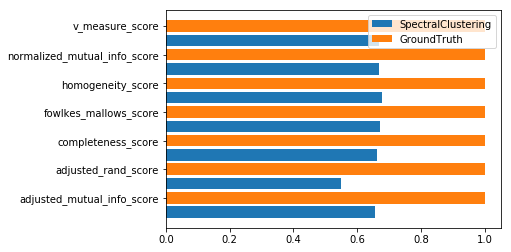

In [11]:
# Example of how the output should look like
compare_clusterings(labels_true=protein["labels"],
                    SpectralClustering=labels_spectral,
                    GroundTruth=protein["labels"])

<p style="background-color:#adebad;">
    Demonstrate your implementation of compare_clusterings below
</p>

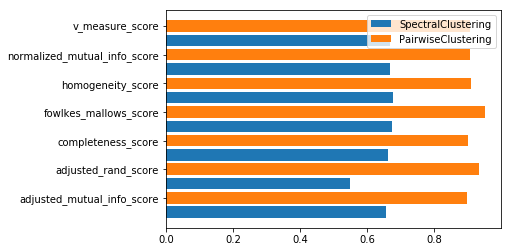

In [12]:
compare_clusterings(labels_true=protein["labels"],
                    SpectralClustering=labels_spectral,
                    PairwiseClustering=labels_pair)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    As PairwiseClustering takes dissimilarities as input, we need to transform the similarity data from Prodom accordingly.<br>
    Run fit_predict with all the transforms/params below, and run one compare_clusterings for each set of parameters.<br>
    Finally, produce a separate compare_clusterings with the best parameter from each transform.
</p>

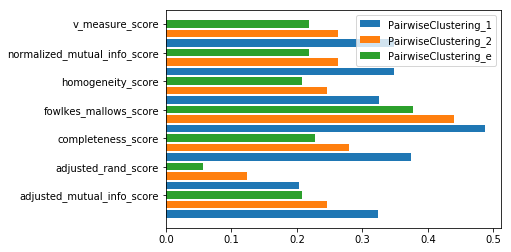

In [13]:
# D = ((max(S) - S) / (max(S) - min(S))) ** a
# a = [1, 2, exp]

l1 = []
for a in [1, 2]:
    D = ((np.max(prodom["similarity"] ) - prodom["similarity"] ) / (np.max(prodom["similarity"] ) - np.min(prodom["similarity"] ))) ** a
    PC = PairwiseClustering()
    labels_pair = PC.fit_predict(D, ti=1e-1, tf=1e-3)
    l1.append(labels_pair)
D = np.exp((np.max(prodom["similarity"] ) - prodom["similarity"] ) / (np.max(prodom["similarity"] ) - np.min(prodom["similarity"] )))
PC = PairwiseClustering()
labels_pair = PC.fit_predict(D, ti=1e-1, tf=1e-2)
l1.append(labels_pair)
compare_clusterings(labels_true=prodom["labels"],
                    PairwiseClustering_1=l1[0],
                    PairwiseClustering_2=l1[1],
                    PairwiseClustering_e=l1[2])

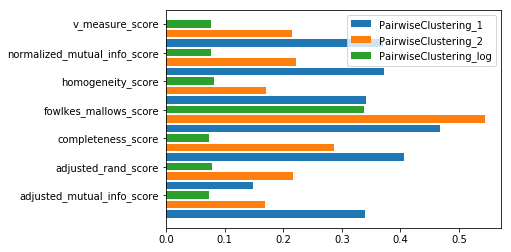

In [14]:
# D = (max(S) / (1 + S - min(S))) ** a
# a = [1, 1/2, log]

l2 = []
for a in [1, 1/2]:
    D = (np.max(prodom["similarity"]) / (1 + prodom["similarity"] - np.min(prodom["similarity"]))) ** a

    PC = PairwiseClustering()
    labels_pair = PC.fit_predict(D, tf=1e-1)
    l2.append(labels_pair)
D = np.log(np.max(prodom["similarity"]) / (1 + prodom["similarity"] - np.min(prodom["similarity"])))

PC = PairwiseClustering()
labels_pair = PC.fit_predict(D, tf=1e-1)
l2.append(labels_pair)
compare_clusterings(labels_true=prodom["labels"],
                    PairwiseClustering_1=l2[0],
                    PairwiseClustering_2=l2[1],
                    PairwiseClustering_log=l2[2])

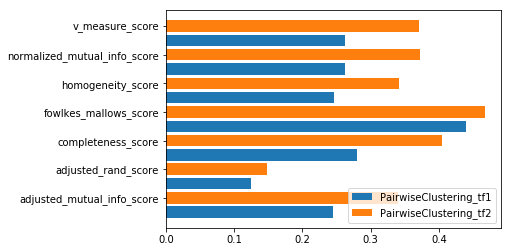

In [15]:
# plotting best of each transform
compare_clusterings(labels_true=prodom["labels"],
                    PairwiseClustering_tf1=l1[1],
                    PairwiseClustering_tf2=l2[0])

<p style="background-color:#adebad;">
    Implement one more reasonable transform from similarity to dissimilarity, and compare it to the other settings.
</p>

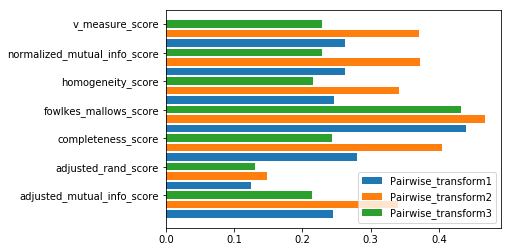

In [16]:
D = np.sqrt(np.max(prodom['similarity'])-prodom['similarity'])

PC = PairwiseClustering()
labels_pair = PC.fit_predict(D, ti=10, tf=1)
compare_clusterings(labels_true=prodom["labels"],
                    Pairwise_transform1=l1[1],
                    Pairwise_transform2=l2[0],
                    Pairwise_transform3=labels_pair)


<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Complete the cost function of the PairwiseClustering class
    </li>
</ul>

<ul style="background-color:#adebad;">
    <li>
        Re-run fit_predict with different random seeds and plot the distribution of clustering costs as shown in figure 1 of reference [1]. <br> Perform the experiment for all the settings listed below, and visualize the results properly.
    </li>
</ul>

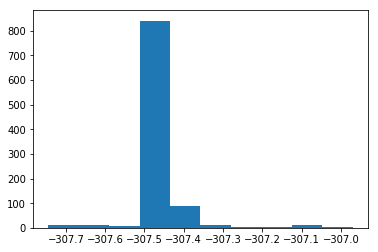

In [17]:
# data = [protein, prodom]
# Use the best transform from Problem 3 to transform similarities
# other parameters are default
costs = []
for rs in range(1000):
    PC = PairwiseClustering(random_state=rs)
    labels_pair = PC.fit_predict(protein["dissimilarity"], ti=1, tf=0.1)
    costs.append(PC.cost(protein["dissimilarity"], PC.M))
plt.hist(np.array(costs)[abs(np.array(costs) - np.mean(costs)) < 0.8 * np.std(costs)], bins=10)
plt.show()

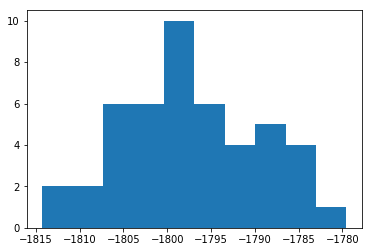

In [18]:
D = (np.max(prodom["similarity"]) / (1 + prodom["similarity"] - np.min(prodom["similarity"]))) ** 0.5
costs = []
for rs in range(50):
    PC = PairwiseClustering(random_state=rs)
    labels_pair = PC.fit_predict(D, ti=1, tf=0.1)
    costs.append(PC.cost(D, PC.M))
plt.hist(np.array(costs)[abs(np.array(costs) - np.mean(costs)) < 0.9 * np.std(costs)], bins=10)
plt.show()

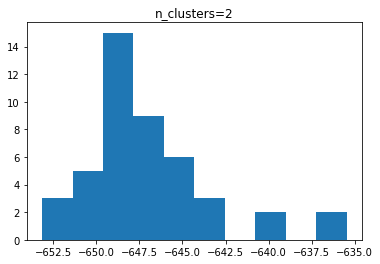

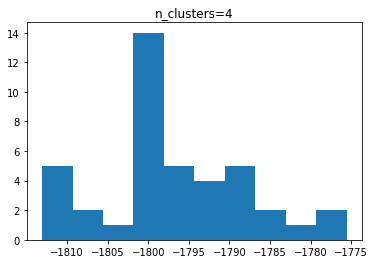

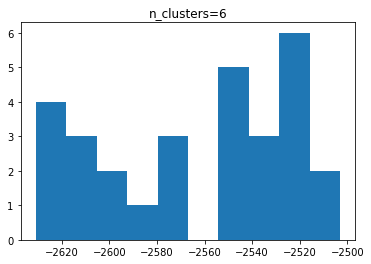

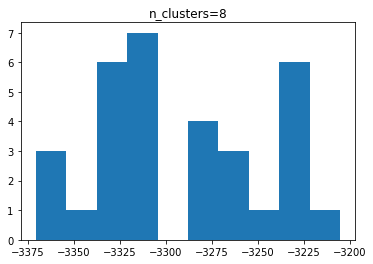

In [19]:
# n_clusters = [2, 4, 6, 8]
# data = protein
# other parameters are default
for n_clusters in [2, 4, 6, 8]:
    costs = []
    plt.figure()
    plt.title('n_clusters={}'.format(n_clusters))
    for rs in range(50):
        PC = PairwiseClustering(random_state=rs, n_clusters=n_clusters)
        labels_pair = PC.fit_predict(D, ti=1, tf=0.1)
        costs.append(PC.cost(D, PC.M))
    plt.hist(np.array(costs)[abs(np.array(costs) - np.mean(costs)) < 0.9 * np.std(costs)], bins=10)
plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
            Write a function to generate a Gaussian distributed random dissimilarity matrix 
        </li>
</ul>

<ul style="background-color:#adebad;">
        <li>
            Implement the refined meanfield approach (TAP method, Section 4.2 in reference [1]) using cavity fields
        </li>
</ul>

<ul style="background-color:#adebad;">
        <li>
            Repeat the Monte Carlo experiments in Section 4.2 and estimate the residual errors for N = {100,200,500,1000,2000}. 
            You may use the MCMC implementation of your choice.
        </li>
</ul>

<h2 style="background-color:#f0b375;">
Section Optional
<span style=font-size:50%> Complete this section to obtain a bonus .5 grade (in case you skipped a section) </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
            Implement the embed == True part of <b>PC.fit_predict</b> (algorithm III).
        </li>
    </ul>

In [20]:
PCE = PairwiseClustering(embed=True, n_clusters=4)
labels_embed = PCE.fit_predict(protein["dissimilarity"], ti=10, tf=0.1)

[[1.45209025 1.4779102 ]
 [1.41694561 1.39324046]
 [1.37917984 1.46230587]
 [1.38723177 1.67644498]
 [1.29239927 1.7538252 ]
 [1.58495068 1.60341136]
 [1.22067308 0.4764066 ]
 [1.60361906 2.08301494]
 [1.57868541 1.69958433]
 [1.20943804 0.75372757]
 [1.31405212 1.57679053]
 [1.34992064 1.35159198]
 [1.34992064 1.35159198]
 [1.11335412 0.19016495]
 [1.45132074 1.93665058]
 [1.36658677 1.55080025]
 [1.55490498 1.51091028]
 [1.67811185 1.64573677]
 [1.57456735 1.38409001]
 [1.58721306 1.4836558 ]
 [1.60009198 1.44817197]
 [1.48862395 1.99500152]
 [1.24066649 1.19519501]
 [1.11279505 0.99195394]
 [1.19764519 1.31571996]
 [1.08786333 0.95562981]
 [1.2274804  1.47857954]
 [1.34862072 1.39134057]
 [1.39044017 1.4637939 ]
 [1.22449083 0.79237498]
 [1.51681665 0.63656073]
 [1.34850931 0.62955354]
 [1.58891269 0.88622019]
 [1.37466428 0.73787577]
 [1.53458469 0.68542148]
 [1.56144658 0.81208408]
 [1.3726356  0.65498838]
 [1.46498394 0.67714653]
 [1.37103692 0.73093567]
 [1.37873355 0.7321804 ]


[[ 1.97050295e+01  1.05471187e-15]
 [ 1.92971422e+01  6.03035693e-01]
 [ 3.80819839e+01 -5.95030998e-01]
 [ 2.50564713e+01  1.95753682e-01]
 [ 1.81512267e+01  5.67225834e-01]
 [ 1.90120718e+01  1.18825449e+00]
 [ 1.84319779e+01  5.75999308e-01]
 [ 1.42108547e-14  5.77953534e-01]
 [-6.21055162e-14  6.03241092e-01]
 [-3.19073678e-14  6.03980529e-01]
 [ 1.84956398e+01  5.77988745e-01]
 [ 0.00000000e+00  4.63434754e-01]
 [ 0.00000000e+00  4.63434754e-01]
 [ 8.17476828e+00  0.00000000e+00]
 [ 1.86779873e+01  5.83687102e-01]
 [ 1.93234333e+01  1.20771458e+00]
 [ 1.86539497e+01  1.16587186e+00]
 [ 1.42108547e-14  5.78481703e-01]
 [ 2.51801645e+01  1.96720035e-01]
 [ 1.83884098e+01  1.14927561e+00]
 [ 1.84393018e+01  5.76228182e-01]
 [-1.42108547e-14  5.87173017e-01]
 [-1.94691099e-14  6.37847900e-01]
 [ 3.38196074e-14  6.19942970e-01]
 [ 1.90691610e+01  1.19182256e+00]
 [ 7.66259396e+01 -5.98640153e-01]
 [ 0.00000000e+00  1.04963946e+00]
 [-1.77021541e-14  5.53170670e-01]
 [ 0.00000000e+00  5

[[ 5.64638456e+06 -4.65661287e-10]
 [ 1.55996531e-08  3.76425637e+06]
 [-1.11758709e-08  3.76425637e+06]
 [ 1.11758709e-08  3.76425637e+06]
 [-1.16415322e-09  3.76425637e+06]
 [ 2.79396772e-09  3.76425637e+06]
 [ 1.88212819e+06  0.00000000e+00]
 [ 5.64638456e+06  0.00000000e+00]
 [ 5.64638456e+06  0.00000000e+00]
 [-2.32830644e-10  1.12927691e+07]
 [ 5.64638456e+06  0.00000000e+00]
 [ 5.64638456e+06  0.00000000e+00]
 [ 5.64638456e+06  0.00000000e+00]
 [ 2.82319228e+06 -5.64638456e+06]
 [-4.65661287e-09  3.76425637e+06]
 [ 1.23400241e-08  3.76425637e+06]
 [ 7.21774995e-09  3.76425637e+06]
 [ 5.64638456e+06 -2.79396772e-09]
 [ 5.64638456e+06  0.00000000e+00]
 [ 1.31748973e+07 -7.52851274e+06]
 [ 4.81824815e+06  2.40912408e+06]
 [-9.31322575e-10  3.76425637e+06]
 [-3.37309746e-09  9.41064093e+06]
 [ 9.41064093e+06  7.52851274e+06]
 [ 1.88212819e+06  0.00000000e+00]
 [ 5.64638456e+06  1.50570255e+07]
 [ 5.64638456e+06 -1.11758709e-08]
 [ 3.76425637e+06  3.76425637e+06]
 [ 3.95812094e-09  3

[[ 6.00071205e+00  5.96447346e-01]
 [ 5.59260395e+00  9.53070222e-01]
 [ 7.15899855e+00 -6.57435728e-01]
 [ 7.29076117e+00 -6.44057777e-01]
 [ 5.96489930e+00  5.23179391e-01]
 [ 6.60861125e+00  5.08407792e-02]
 [ 5.59458866e+00  8.84963996e-01]
 [ 5.14810494e+00  1.36125615e+00]
 [ 5.84860664e+00  6.78813944e-01]
 [ 6.80097529e+00 -2.27869827e-01]
 [ 2.95468575e+01 -2.17672860e+01]
 [ 5.30656359e+00  8.61933221e-01]
 [ 5.30656359e+00  8.61933221e-01]
 [ 1.25134811e+01 -5.90023906e+00]
 [ 5.74125088e+00  5.33685820e-01]
 [ 4.58976963e+00  1.63220818e+00]
 [ 6.11022664e+00  2.24660763e-01]
 [ 3.41095268e+00  2.75086820e+00]
 [-5.39712991e-01  6.48927128e+00]
 [ 4.51275762e+00  1.72663750e+00]
 [ 5.22924246e+00  1.05693995e+00]
 [ 5.06742459e+00  1.17276958e+00]
 [ 5.20538712e+00  1.12553149e+00]
 [ 6.77767129e+00 -2.92161270e-01]
 [ 7.14687444e+00 -7.01921289e-01]
 [ 2.51928808e+00  3.66741106e+00]
 [ 1.72098104e+00  4.25956191e+00]
 [ 4.29043085e+00  1.85843090e+00]
 [-5.06395654e+01  5

[[-2.15067531e+34  3.18511456e+34]
 [ 3.76506701e+33  6.21552924e+34]
 [-4.69509698e+35 -5.05483518e+35]
 [-4.69383302e+34  1.35193377e+33]
 [-3.13805973e+34  2.00111254e+34]
 [-1.89200572e+34  3.49501951e+34]
 [ 2.00375352e+35  2.97981551e+35]
 [-5.09877840e+34 -3.50456575e+33]
 [ 1.16420176e+35  1.97287637e+35]
 [-2.35199998e+34  2.94423554e+34]
 [-5.43987503e+37 -6.51885632e+37]
 [-9.77925912e+37 -1.17235421e+38]
 [-9.77925912e+37 -1.17235421e+38]
 [-9.68901517e+37 -1.16153021e+38]
 [ 1.56544910e+35  2.45373769e+35]
 [-1.15567365e+35 -8.09733657e+34]
 [-3.84853107e+34  1.14876176e+34]
 [-3.32816669e+34  1.77324798e+34]
 [-1.16584826e+35 -8.21818720e+34]
 [-3.93550559e+34  1.04470001e+34]
 [-1.46557554e+34  4.00724761e+34]
 [-1.29029171e+35 -9.71393265e+34]
 [ 2.18470231e+37  2.62611045e+37]
 [ 1.84792745e+36  2.27401149e+36]
 [ 2.72220989e+37  3.27079780e+37]
 [-4.50218992e+37 -5.39419115e+37]
 [-1.04300163e+38 -1.25040637e+38]
 [-9.48637444e+37 -1.13722535e+38]
 [-9.96337180e+37 -1

In [21]:
print(labels_embed)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2]


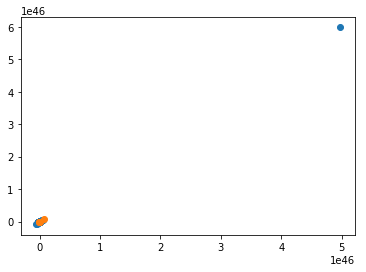

In [22]:
plt.scatter(*PCE.embeddings.T)
plt.scatter(*PCE.centroids.T)
plt.show()

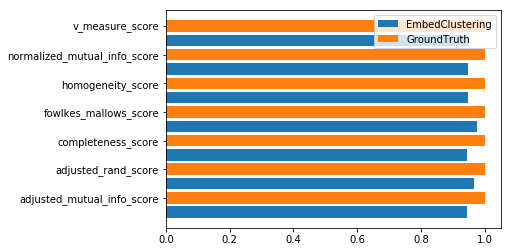

In [23]:
compare_clusterings(labels_true=protein["labels"],
                    EmbedClustering=labels_embed,
                    GroundTruth=protein["labels"])

<ul style="background-color:#adebad;">
        <li>
        Cluster the protein data, and properly visualize the the embedding for n_components=2.
        </li>
    </ul>

In [24]:
# Visualize PCE.embeddings, including PCE.centroids

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.